# 论文3：理解LSTM网络
## Christopher Olah

### 带有门控可视化的LSTM实现

LSTM（长短期记忆）网络通过门控记忆细胞解决梯度消失问题。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## LSTM单元实现

LSTM有三个门：
1. **遗忘门**：从细胞状态中遗忘什么
2. **输入门**：添加什么新信息
3. **输出门**：基于细胞状态输出什么

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # 为效率而连接的权重: [input; hidden] -> gates
        concat_size = input_size + hidden_size
        
        # 遗忘门
        self.Wf = np.random.randn(hidden_size, concat_size) * 0.01
        self.bf = np.zeros((hidden_size, 1))
        
        # 输入门
        self.Wi = np.random.randn(hidden_size, concat_size) * 0.01
        self.bi = np.zeros((hidden_size, 1))
        
        # 候选细胞状态
        self.Wc = np.random.randn(hidden_size, concat_size) * 0.01
        self.bc = np.zeros((hidden_size, 1))
        
        # 输出门
        self.Wo = np.random.randn(hidden_size, concat_size) * 0.01
        self.bo = np.zeros((hidden_size, 1))
    
    def forward(self, x, h_prev, c_prev):
        """
        LSTM单元的前向传播
        
        x: 输入 (input_size, 1)
        h_prev: 前一个隐藏状态 (hidden_size, 1)
        c_prev: 前一个细胞状态 (hidden_size, 1)
        
        返回:
        h_next: 下一个隐藏状态
        c_next: 下一个细胞状态
        cache: 反向传播所需的值
        """
        # 连接输入和前一个隐藏状态
        concat = np.vstack([x, h_prev])
        
        # 遗忘门: 决定从细胞状态中遗忘什么
        f = sigmoid(np.dot(self.Wf, concat) + self.bf)
        
        # 输入门: 决定存储什么新信息
        i = sigmoid(np.dot(self.Wi, concat) + self.bi)
        
        # 候选细胞状态: 可能添加的新信息
        c_tilde = np.tanh(np.dot(self.Wc, concat) + self.bc)
        
        # 更新细胞状态: 遗忘 + 输入新信息
        c_next = f * c_prev + i * c_tilde
        
        # 输出门: 决定输出什么
        o = sigmoid(np.dot(self.Wo, concat) + self.bo)
        
        # 隐藏状态: 过滤的细胞状态
        h_next = o * np.tanh(c_next)
        
        # 为反向传播缓存
        cache = (x, h_prev, c_prev, concat, f, i, c_tilde, c_next, o, h_next)
        
        return h_next, c_next, cache

# 测试LSTM单元
input_size = 10
hidden_size = 20
lstm_cell = LSTMCell(input_size, hidden_size)

x = np.random.randn(input_size, 1)
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

h_next, c_next, cache = lstm_cell.forward(x, h, c)
print(f"LSTM单元已初始化: input_size={input_size}, hidden_size={hidden_size}")
print(f"隐藏状态形状: {h_next.shape}")
print(f"细胞状态形状: {c_next.shape}")

LSTM单元已初始化: input_size=10, hidden_size=20
隐藏状态形状: (20, 1)
细胞状态形状: (20, 1)


## 用于序列处理的全LSTM网络

In [3]:
class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        self.cell = LSTMCell(input_size, hidden_size)
        
        # 输出层
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        self.by = np.zeros((output_size, 1))
    
    def forward(self, inputs):
        """
        通过LSTM处理序列
        inputs: 输入向量列表
        """
        h = np.zeros((self.hidden_size, 1))
        c = np.zeros((self.hidden_size, 1))
        
        # 存储状态以供可视化
        h_states = []
        c_states = []
        gate_values = {'f': [], 'i': [], 'o': []}
        
        for x in inputs:
            h, c, cache = self.cell.forward(x, h, c)
            h_states.append(h.copy())
            c_states.append(c.copy())
            
            # 从缓存中提取门值
            _, _, _, _, f, i, _, _, o, _ = cache
            gate_values['f'].append(f.copy())
            gate_values['i'].append(i.copy())
            gate_values['o'].append(o.copy())
        
        # 最终输出
        y = np.dot(self.Why, h) + self.by
        
        return y, h_states, c_states, gate_values

# 创建LSTM模型
input_size = 5
hidden_size = 16
output_size = 5
lstm = LSTM(input_size, hidden_size, output_size)
print(f"\nLSTM模型已创建: {input_size} -> {hidden_size} -> {output_size}")


LSTM模型已创建: 5 -> 16 -> 5


## 在合成序列任务上测试：长期依赖

任务：记住序列开头的值并在结尾输出

In [4]:
def generate_long_term_dependency_data(seq_length=20, num_samples=100):
    """
    生成序列，其中第一个元素必须被记住直到结尾
    """
    X = []
    y = []
    
    for _ in range(num_samples):
        # 创建序列
        sequence = []
        
        # 第一个元素是重要的（独热编码）
        first_elem = np.random.randint(0, input_size)
        first_vec = np.zeros((input_size, 1))
        first_vec[first_elem] = 1
        sequence.append(first_vec)
        
        # 其余是随机噪声
        for _ in range(seq_length - 1):
            noise = np.random.randn(input_size, 1) * 0.1
            sequence.append(noise)
        
        X.append(sequence)
        
        # 目标: 记住第一个元素
        target = np.zeros((output_size, 1))
        target[first_elem] = 1
        y.append(target)
    
    return X, y

# 生成测试数据
X_test, y_test = generate_long_term_dependency_data(seq_length=15, num_samples=10)

# 测试前向传播
output, h_states, c_states, gate_values = lstm.forward(X_test[0])

print(f"\n测试序列长度: {len(X_test[0])}")
print(f"第一个元素（要记住）: {np.argmax(X_test[0][0])}")
print(f"期望输出: {np.argmax(y_test[0])}")
print(f"模型输出（未训练）: {output.flatten()[:5]}")


测试序列长度: 15
第一个元素（要记住）: 1
期望输出: 1
模型输出（未训练）: [-1.28946089e-06  2.81697639e-05 -5.13749904e-07  3.95133884e-06
 -3.06927689e-08]


## 可视化LSTM门

理解LSTM的关键是看门如何随时间操作。

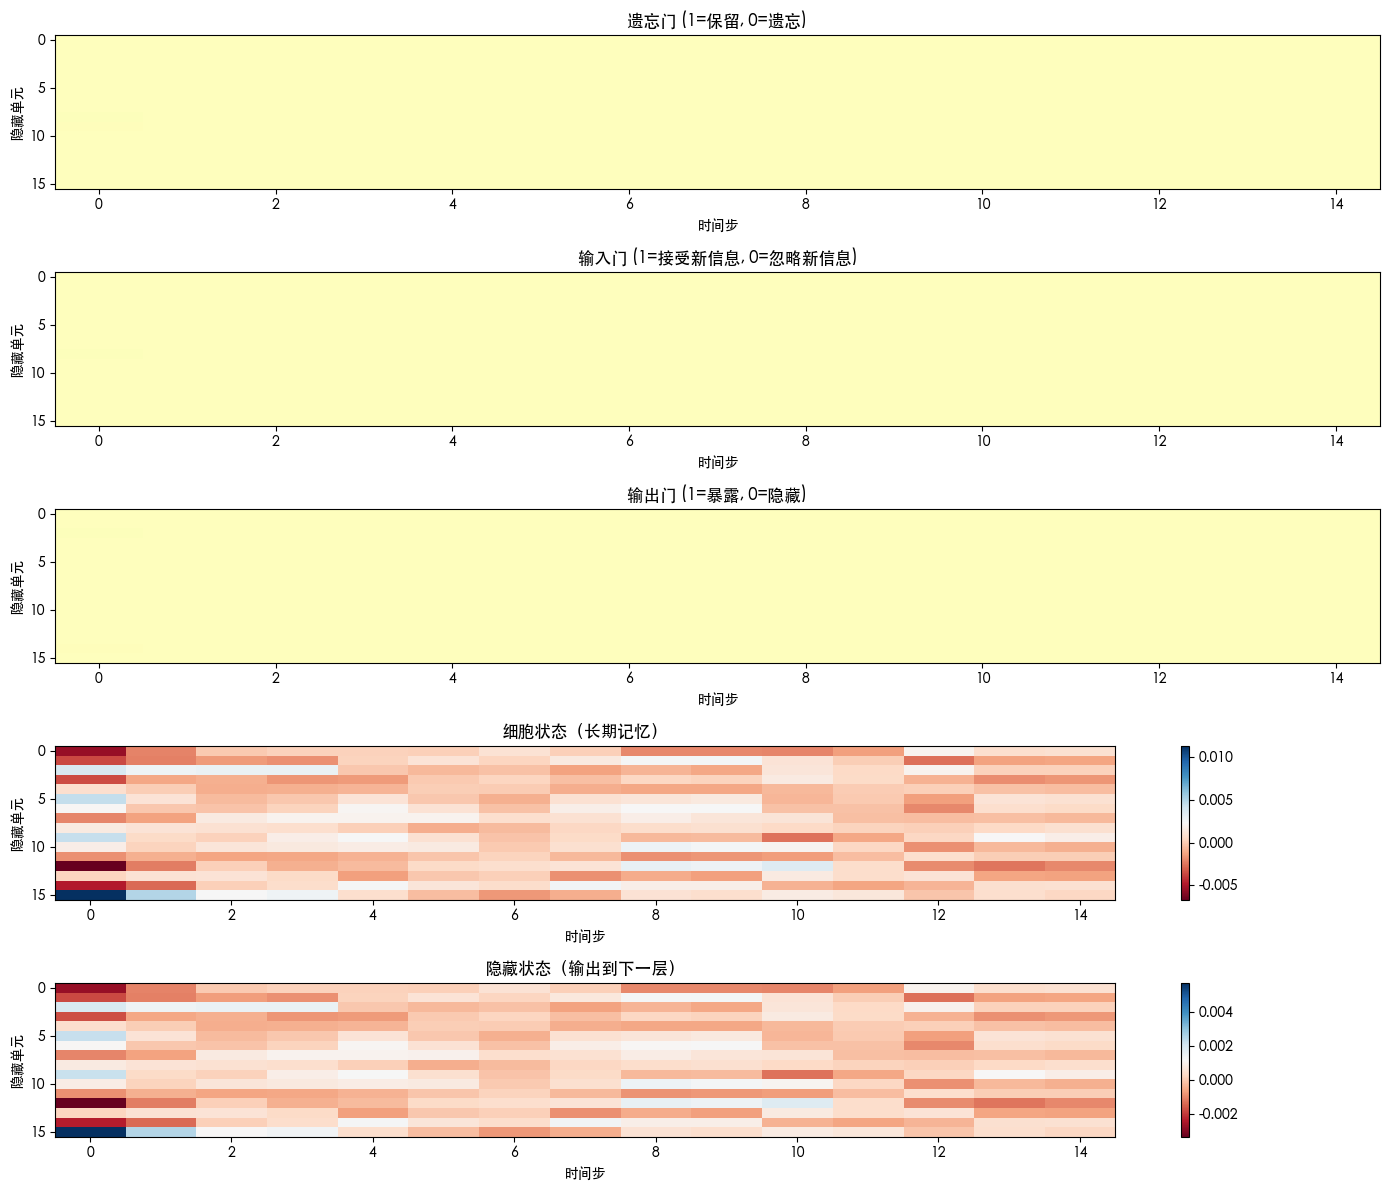


门解释:
- 遗忘门控制从细胞状态中丢弃什么信息
- 输入门控制向细胞状态添加什么新信息
- 输出门控制从细胞状态输出什么
- 细胞状态是长期记忆高速公路


In [5]:
# 处理序列并可视化门
test_seq = X_test[0]
output, h_states, c_states, gate_values = lstm.forward(test_seq)

# 转换为数组以供绘图
forget_gates = np.hstack(gate_values['f'])
input_gates = np.hstack(gate_values['i'])
output_gates = np.hstack(gate_values['o'])
cell_states = np.hstack(c_states)
hidden_states = np.hstack(h_states)

fig, axes = plt.subplots(5, 1, figsize=(14, 12))

# 遗忘门
axes[0].imshow(forget_gates, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[0].set_title('遗忘门 (1=保留, 0=遗忘)')
axes[0].set_ylabel('隐藏单元')
axes[0].set_xlabel('时间步')

# 输入门
axes[1].imshow(input_gates, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('输入门 (1=接受新信息, 0=忽略新信息)')
axes[1].set_ylabel('隐藏单元')
axes[1].set_xlabel('时间步')

# 输出门
axes[2].imshow(output_gates, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[2].set_title('输出门 (1=暴露, 0=隐藏)')
axes[2].set_ylabel('隐藏单元')
axes[2].set_xlabel('时间步')

# 细胞状态
im3 = axes[3].imshow(cell_states, cmap='RdBu', aspect='auto')
axes[3].set_title('细胞状态（长期记忆）')
axes[3].set_ylabel('隐藏单元')
axes[3].set_xlabel('时间步')
plt.colorbar(im3, ax=axes[3])

# 隐藏状态
im4 = axes[4].imshow(hidden_states, cmap='RdBu', aspect='auto')
axes[4].set_title('隐藏状态（输出到下一层）')
axes[4].set_ylabel('隐藏单元')
axes[4].set_xlabel('时间步')
plt.colorbar(im4, ax=axes[4])

plt.tight_layout()
plt.show()

print("\n门解释:")
print("- 遗忘门控制从细胞状态中丢弃什么信息")
print("- 输入门控制向细胞状态添加什么新信息")
print("- 输出门控制从细胞状态输出什么")
print("- 细胞状态是长期记忆高速公路")

## 比较LSTM与原始RNN在长序列上的表现

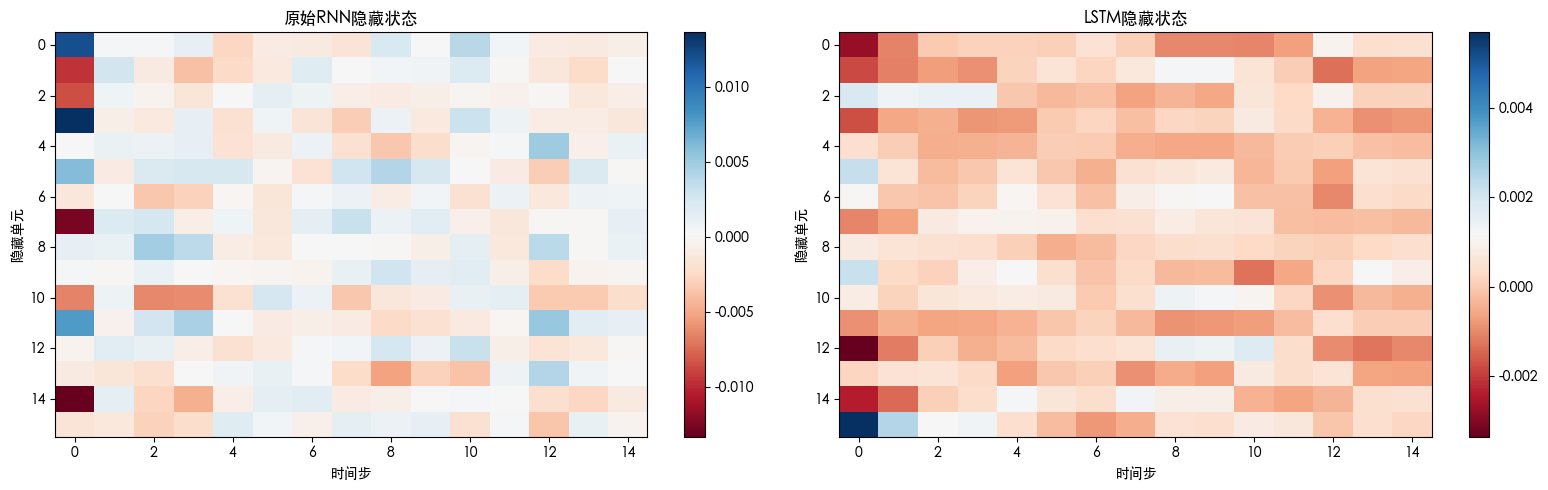


关键差异:
- LSTM将细胞状态与隐藏状态分开维护
- 门允许选择性信息流
- 更好的梯度通过时间的流动（解决梯度消失）


In [6]:
class VanillaRNNCell:
    def __init__(self, input_size, hidden_size):
        concat_size = input_size + hidden_size
        self.Wh = np.random.randn(hidden_size, concat_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.hidden_size = hidden_size
    
    def forward(self, x, h_prev):
        concat = np.vstack([x, h_prev])
        h_next = np.tanh(np.dot(self.Wh, concat) + self.bh)
        return h_next

# 创建用于比较的原始RNN
rnn_cell = VanillaRNNCell(input_size, hidden_size)

def process_with_vanilla_rnn(inputs):
    h = np.zeros((hidden_size, 1))
    h_states = []
    
    for x in inputs:
        h = rnn_cell.forward(x, h)
        h_states.append(h.copy())
    
    return h_states

# 用两者处理相同的序列
rnn_h_states = process_with_vanilla_rnn(test_seq)
rnn_hidden = np.hstack(rnn_h_states)

# 比较隐藏状态演化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

im1 = ax1.imshow(rnn_hidden, cmap='RdBu', aspect='auto')
ax1.set_title('原始RNN隐藏状态')
ax1.set_ylabel('隐藏单元')
ax1.set_xlabel('时间步')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(hidden_states, cmap='RdBu', aspect='auto')
ax2.set_title('LSTM隐藏状态')
ax2.set_ylabel('隐藏单元')
ax2.set_xlabel('时间步')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

print("\n关键差异:")
print("- LSTM将细胞状态与隐藏状态分开维护")
print("- 门允许选择性信息流")
print("- 更好的梯度通过时间的流动（解决梯度消失）")

## 梯度流比较

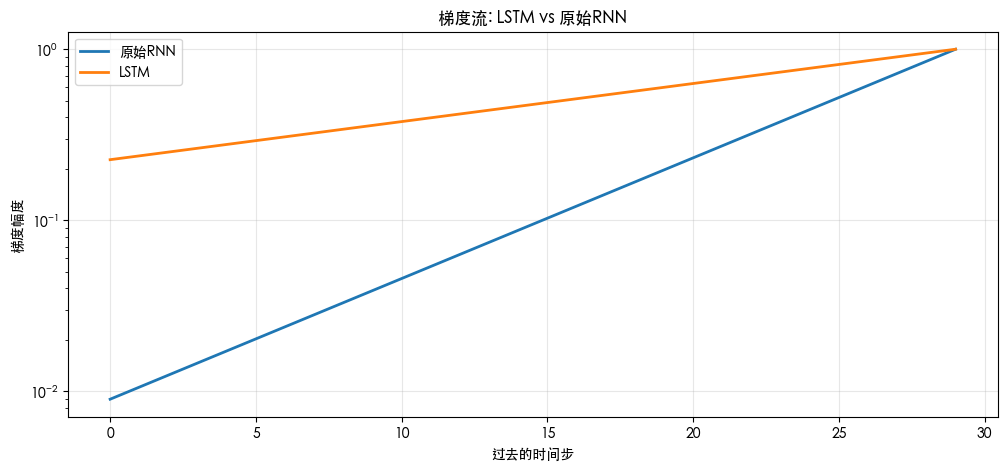


30步后的梯度:
原始RNN: 0.008977 (消失)
LSTM: 0.225936 (保持)

这就是为什么LSTM可以学习长期依赖！


In [7]:
# 模拟梯度幅度
def simulate_gradient_flow(seq_length=30):
    """
    模拟梯度在原始RNN与LSTM中如何衰减
    """
    # 原始RNN: 梯度指数衰减
    rnn_grads = []
    grad = 1.0
    decay_factor = 0.85  # 原始RNN中的典型衰减
    
    for t in range(seq_length):
        rnn_grads.append(grad)
        grad *= decay_factor
    
    # LSTM: 通过细胞状态高速公路保持梯度
    lstm_grads = []
    grad = 1.0
    forget_gate_avg = 0.95  # 高遗忘门 = 保持梯度
    
    for t in range(seq_length):
        lstm_grads.append(grad)
        grad *= forget_gate_avg  # 遗忘门控制梯度流
    
    return np.array(rnn_grads), np.array(lstm_grads)

rnn_grads, lstm_grads = simulate_gradient_flow()

plt.figure(figsize=(12, 5))
plt.plot(rnn_grads[::-1], label='原始RNN', linewidth=2)
plt.plot(lstm_grads[::-1], label='LSTM', linewidth=2)
plt.xlabel('过去的时间步')
plt.ylabel('梯度幅度')
plt.title('梯度流: LSTM vs 原始RNN')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

print(f"\n30步后的梯度:")
print(f"原始RNN: {rnn_grads[-1]:.6f} (消失)")
print(f"LSTM: {lstm_grads[-1]:.6f} (保持)")
print(f"\n这就是为什么LSTM可以学习长期依赖！")

## 关键要点

### LSTM架构：
1. **细胞状态**：跨时间信息流的高速公路
2. **遗忘门**：控制从记忆中删除什么
3. **输入门**：控制添加什么新信息
4. **输出门**：控制从记忆中输出什么

### 为什么LSTM有效：
- **恒定误差轮播**：细胞状态提供不间断的梯度流
- **乘性门**：允许网络学习何时记忆/遗忘
- **加性更新**：细胞状态通过加法更新（f*c + i*c_tilde）
- **梯度保持**：接近1的遗忘门保持梯度

### 相比原始RNN的优势：
- 解决梯度消失问题
- 学习长期依赖（100+时间步）
- 更稳定的训练
- 在真实序列任务上表现更好